In [16]:
#📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [17]:
#📄 Chargement du fichier optimisé
df = pd.read_parquet('../data/parquet/optimized_2020.parquet')
print(f"Shape: {df.shape}")

Shape: (2065003, 40)


In [18]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1,2020-07-01,1,Vente,31234.160156,NaN,nan,SAINT JULIEN,B064,1560.0,01367,Saint-Julien-sur-Reyssouze,01,NaN,nan,013670000A0008,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,AB,terrains a bâtir,nan,nan,1192.0,5.109255,46.403019
1,2020-2,2020-07-01,1,Vente,278000.000000,NaN,nan,A LA PEROUSE,B188,1250.0,01125,Corveissiat,01,NaN,nan,011250000C0509,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,BS,taillis sous futaie,nan,nan,10092.0,5.444577,46.252373
2,2020-2,2020-07-01,1,Vente,278000.000000,NaN,nan,A LA PEROUSE,B188,1250.0,01125,Corveissiat,01,NaN,nan,011250000C0510,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,L,landes,nan,nan,4570.0,5.444588,46.253468
3,2020-2,2020-07-01,1,Vente,278000.000000,NaN,nan,AUX COMMUNS,B079,1250.0,01125,Corveissiat,01,NaN,nan,01125000ZL0096,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,BS,taillis sous futaie,nan,nan,5750.0,5.442015,46.256031
4,2020-2,2020-07-01,1,Vente,278000.000000,NaN,nan,EN COMBARNAUD,B033,1250.0,01408,Simandre-sur-Suran,01,NaN,nan,014080000A0014,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,0,NaN,nan,NaN,NaN,BT,taillis simples,nan,nan,648170.0,5.439915,46.250793


In [19]:
df['nature_mutation'].value_counts(normalize=True)

nature_mutation
Vente                                 0.907421
Vente en l'état futur d'achèvement    0.076005
Echange                               0.010075
Adjudication                          0.003356
Vente terrain à bâtir                 0.002708
Expropriation                         0.000434
Name: proportion, dtype: float64

## 🔎 Qu’est-ce qu’une mutation ?

Dans les données **DVF** (demandes de valeurs foncières), une mutation correspond à un acte juridique de transfert de propriété, le plus souvent une vente immobilière.

Une même mutation peut regrouper plusieurs biens ou lots (appartement, cave, parking, parcelles) vendus ensemble lors d’un seul acte notarié, et partageant un prix global unique.

👉 Ainsi, une mutation ne correspond pas nécessairement à un seul logement, mais à une transaction immobilière.

## Pourquoi choisir les ventes ?

Les données DVF regroupent plusieurs natures de mutations correspondant à des contextes juridiques et économiques distincts. L’analyse de leur répartition montre que les ventes classiques représentent l’écrasante majorité des transactions (environ 91 %), tandis que les autres natures de mutations sont marginales.

Afin de garantir la cohérence et la comparabilité des observations, cette étude se concentre exclusivement sur les mutations de type « Vente ». Ce choix s’explique par plusieurs raisons :

Les ventes correspondent à des transactions de marché standard, reflétant directement la rencontre de l’offre et de la demande.

Les autres natures de mutations (VEFA, adjudications, échanges, expropriations) obéissent à des logiques de prix spécifiques :
* les **VEFA** concernent des biens neufs, avec des prix structurellement plus élevés et des surfaces parfois prévisionnelles.
* les **adjudications** et **expropriations** ne résultent pas d’un libre jeu du marché.
* les **échanges** ne comportent pas nécessairement de prix de marché comparable.
* les **ventes de terrains à bâtir** relèvent d’une dynamique foncière distincte du logement bâti.

L’inclusion de ces mutations introduirait une hétérogénéité forte dans la variable cible, susceptible de biaiser l’analyse exploratoire et la modélisation.

En se limitant aux ventes, le périmètre d’étude reste homogène, interprétable et représentatif du marché immobilier résidentiel existant, permettant de construire des modèles de prédiction plus robustes et plus fiables.

In [20]:
# Filtrage des ventes
df_ventes = df.loc[df['nature_mutation'] == 'Vente'].copy()
print(f"Shape after filtering ventes: {df_ventes.shape}")

Shape after filtering ventes: (1873828, 40)


In [21]:
# Distribution des types de locaux
df_ventes['type_local'].value_counts(normalize=True)

type_local
nan                                         0.409609
Maison                                      0.220911
Appartement                                 0.168589
Dépendance                                  0.165044
Local industriel. commercial ou assimilé    0.035847
Name: proportion, dtype: float64

## Choix du périmètre : focus sur les appartements

L’analyse de la variable type_local met en évidence une forte hétérogénéité des biens présents dans les données DVF. En particulier, près de 43 % des observations ne disposent pas d’un type de bien renseigné, tandis que les autres catégories regroupent des biens aux caractéristiques et aux logiques de valorisation très différentes.

Parmi les types identifiés, les appartements représentent environ 16,5 % des observations, constituant le segment résidentiel le plus homogène et le mieux caractérisé du jeu de données. À l’inverse, les maisons (20,2 %) impliquent des composantes supplémentaires telles que le terrain et les dépendances, rendant la comparaison des prix plus complexe, tandis que les dépendances et les locaux commerciaux relèvent de dynamiques de marché distinctes.

Dans ce contexte, le choix de se concentrer exclusivement sur les appartements permet :
* de limiter l’impact des valeurs manquantes et des ambiguïtés de typologie.
* de travailler sur des biens comparables entre eux, pour lesquels le prix au mètre carré est une métrique pertinente.
* de réduire l’hétérogénéité structurelle du jeu de données, condition nécessaire à une analyse exploratoire et à une modélisation fiables.

Ce périmètre restreint garantit ainsi une meilleure robustesse des résultats et une interprétation plus fidèle du marché immobilier résidentiel.

In [22]:
# Création d'une colonne booleenne pour filtrer les appartements
df_ventes["is_appartement"] = df_ventes["type_local"].eq("Appartement")

# Filtrage des mutations avec au moins un appartement
df_ventes_app_mut = (
    df_ventes
    .groupby("id_mutation", as_index=False)
    .filter(lambda g: g["is_appartement"].any())
    .copy()
) 

In [23]:
df_ventes_app_mut.head(10)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,is_appartement
45,2020-15,2020-07-02,1,Vente,136000.0,22.0,nan,RUE GEN DELESTRAINT,1650,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AM0095,nan,nan,127,NaN,144,61.200001,nan,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,62.0,3.0,nan,nan,nan,nan,NaN,5.219443,46.198795,True
46,2020-15,2020-07-02,1,Vente,136000.0,22.0,B,RUE GEN DELESTRAINT,1650,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AM0095,nan,nan,9,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,nan,nan,nan,nan,NaN,5.219443,46.198795,False
56,2020-22,2020-07-01,1,Vente,270000.0,10.0,nan,RUE GABRIEL VICAIRE,1610,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AC0143,nan,nan,21,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,nan,nan,nan,nan,NaN,5.224621,46.208263,False
57,2020-22,2020-07-01,1,Vente,270000.0,10.0,nan,RUE GABRIEL VICAIRE,1610,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AC0143,nan,nan,12,NaN,7,NaN,nan,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,111.0,2.0,nan,nan,nan,nan,NaN,5.224621,46.208263,True
58,2020-22,2020-07-01,1,Vente,270000.0,6.0,nan,RUE CREVE COEUR,1030,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AC0144,nan,nan,186,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,nan,nan,nan,nan,NaN,5.224445,46.208599,False
59,2020-22,2020-07-01,1,Vente,270000.0,4.0,B,RUE CREVE COEUR,1030,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AC0144,nan,nan,194,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,31.0,2.0,nan,nan,nan,nan,NaN,5.224445,46.208599,True
60,2020-22,2020-07-01,1,Vente,270000.0,6.0,nan,RUE CREVE COEUR,1030,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AC0144,nan,nan,177,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,nan,nan,nan,nan,NaN,5.224445,46.208599,False
78,2020-34,2020-07-09,1,Vente,72000.0,110.0,nan,RUE DU PRE PAQUIER,0443,1750.0,01370,Saint-Laurent-sur-Saône,01,NaN,nan,013700000A0680,nan,nan,79,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,nan,nan,nan,nan,NaN,4.842984,46.307400,False
79,2020-34,2020-07-09,1,Vente,72000.0,110.0,nan,RUE DU PRE PAQUIER,0443,1750.0,01370,Saint-Laurent-sur-Saône,01,NaN,nan,013700000A0680,nan,nan,16,48.099998,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,47.0,2.0,nan,nan,nan,nan,NaN,4.842984,46.307400,True
108,2020-45,2020-07-10,1,Vente,70000.0,20.0,nan,RUE BOURGMAYER,0570,1000.0,01053,Bourg-en-Bresse,01,NaN,nan,01053000AD0650,nan,nan,11,45.660000,2,NaN,nan,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,46.0,2.0,nan,nan,nan,nan,NaN,5.222975,46.205639,True


In [24]:
df_ventes_app_mut['type_local'].value_counts(normalize=True)

type_local
Appartement                                 0.566789
Dépendance                                  0.368169
nan                                         0.035846
Local industriel. commercial ou assimilé    0.019508
Maison                                      0.009689
Name: proportion, dtype: float64

### Observations:
* **Dépendance** (36.8%) : cave, parking, garage… très fréquent avec un appart 
* **NaN** (3.6%) : parcelles/cultures (sols, jardins) ou type non renseigné 
* **Local commercial** (1.95%) : vente mixte (ex : immeuble avec local au RDC) 
* **Maison** (0.97%) : mutation composite (rare mais possible) 

Donc ces proportions ne sont pas un bug : elles confirment que DVF décrit aussi des actes de vente multi-lots.

## Prise de décisision

Faut-il garder les mutations mixtes/composites (avec local commercial/maison) ou faire un dataset appartement purs ?

In [25]:
# Analyse des mixes de types de locaux dans les mutations avec appartements
mix = (
    df_ventes_app_mut.groupby("id_mutation")["type_local"]
    .apply(lambda s: sorted(set(s.dropna().unique())))
)

mix.value_counts().head(10)


type_local
[Appartement, Dépendance]                                                   121482
[Appartement]                                                                92914
[Appartement, Local industriel. commercial ou assimilé]                       3514
[Appartement, Dépendance, nan]                                                2850
[Appartement, nan]                                                            2760
[Appartement, Dépendance, Local industriel. commercial ou assimilé]           1594
[Appartement, Local industriel. commercial ou assimilé, nan]                   763
[Appartement, Maison]                                                          635
[Appartement, Dépendance, Local industriel. commercial ou assimilé, nan]       436
[Appartement, Maison, nan]                                                     363
Name: count, dtype: int64

La très grande majorité des mutations avec appartement relève de logements résidentiels cohérents (appartement avec dépendance / appartement seul).
Les cas mixtes existent, mais sont marginaux.

Puisque notre objectif est de **prédire le prix d'appartements comparables entre eux**, nous faisons le choix de ne retenir uniquement les mutations où l'appartement est le bien résidentiel principal.

Nous conserverons donc les mutations suivantes:
* Appartement
* Appartement, Dépendance
* Appartement, nan
* Appartement, Dépendance, nan

Et excluerons les mutations suivantes:
* Toutes mutations contenant:
  * Local industriel. commercial ou assimilé
  * Maison

<u>Règle métier finale</u>:  
*Une mutation est considérée comme une vente d’appartement exploitable si elle contient au moins un lot de type Appartement et qu’aucun autre type résidentiel ou commercial (Maison, Local industriel. commercial ou assimilé) n’est présent. Les dépendances et lignes non typées sont tolérées.*

In [26]:
# Définition des types de locaux autorisés et interdits
ALLOWED_TYPES = {"Appartement", "Dépendance"}
FORBIDDEN_TYPES = {
    "Maison",
    "Local industriel. commercial ou assimilé"
}

# Identification des mutations valides
valid_ids = (
    df_ventes_app_mut
    .groupby("id_mutation")["type_local"]
    .apply(
        lambda s: (
            "Appartement" in set(s.dropna())
            and set(s.dropna()).issubset(ALLOWED_TYPES)
        )
    )
)
# Filtrage final des ventes d'appartements
df_ventes_app_clean = df_ventes_app_mut[
    df_ventes_app_mut["id_mutation"].isin(valid_ids[valid_ids].index)
].copy()


In [27]:
# Résultat final
print(f"Final shape: {df_ventes_app_clean.shape}")
df_ventes_app_clean['type_local'].value_counts(normalize=True)

Final shape: (424566, 41)


type_local
Appartement    0.590365
Dépendance     0.409635
Name: proportion, dtype: float64

In [35]:
# Agrégation par mutation pour les appartements
app_count_per_mut = (
    df_ventes_app_clean[df_ventes_app_clean["is_appartement"]]
    .groupby("id_mutation")
    .size()
)
# Nombre de mutations avec plus d'un appartement
nb_mutations_multi_app = (app_count_per_mut > 1).sum()
print("Mutations avec >1 appartement :", nb_mutations_multi_app)


Mutations avec >1 appartement : 13850


In [36]:
# mutations qui ont au moins 1 appartement
nb_mutations_total = app_count_per_mut.shape[0]  
print("Total mutations avec >=1 appart :", nb_mutations_total)
print("Part multi-app :", nb_mutations_multi_app / nb_mutations_total)


Total mutations avec >=1 appart : 214396
Part multi-app : 0.06460008582249668


In [43]:
# Distribution du nombre d'appartements par mutation
app_count_per_mut.value_counts().sort_index().head(10)


1     200546
2       8183
3       2171
4       1401
5        544
6        536
7        235
8        207
9        113
10        77
Name: count, dtype: int64

In [44]:
# Pourcentage de mutations avec un seul appartement
single_app_percentage = (app_count_per_mut == 1).mean() * 100
print(f"Pourcentage de mutations avec un seul appartement : {single_app_percentage:.2f}%")

Pourcentage de mutations avec un seul appartement : 93.54%


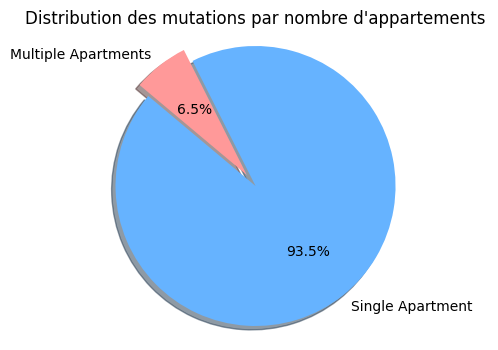

In [ ]:
# pie chart visualization of single vs multi apartment mutations
labels = ['Single Apartment', 'Multiple Apartments']
sizes = [single_app_percentage, 100 - single_app_percentage]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode the 1st slice     
plt.figure(figsize=(6, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution des mutations par nombre d\'appartements')
plt.axis('equal')  
plt.show()

In [29]:
# Fonction d'agrégation des mutations avec appartements

def agg_appartement(g: pd.DataFrame) -> pd.Series:
    """
    Agrège une mutation DVF contenant au moins un appartement
    en une seule observation exploitable.

    Règles :
    - 1 mutation = 1 ligne
    - surface_bati et nb_pieces calculés UNIQUEMENT à partir des lignes de type 'Appartement'
    - les dépendances et lignes NaN sont ignorées pour les calculs mais tolérées dans la mutation
    """
    
    app = g[g["is_appartement"]]

    out = {}

    # --- Identité de la mutation ---
    out["valeur_fonciere"] = g["valeur_fonciere"].iloc[0]
    out["date_mutation"] = g["date_mutation"].iloc[0]
    out["nature_mutation"] = g["nature_mutation"].iloc[0]

    # --- Surfaces / volumes (reconstruits) ---
    out["surface_bati"] = app["surface_reelle_bati"].sum(min_count=1)
    out["nb_pieces"] = app["nombre_pieces_principales"].sum(min_count=1)
    out["nb_lots_appartement"] = len(app)

    # --- Indicateurs de complexité de la mutation ---
    out["nb_lignes_mutation"] = len(g)
    out["presence_dependance"] = (g["type_local"] == "Dépendance").any()
    out["presence_nan_type"] = g["type_local"].isna().any()

    # --- Colonnes géographiques / administratives (brutes) ---
    for col in [
        "code_commune",
        "nom_commune",
        "code_departement",
        "code_postal",
        "longitude",
        "latitude"
    ]:
        out[col] = g[col].iloc[0]

    return pd.Series(out)

In [30]:
df_app_agg = (
    df_ventes_app_clean
    .groupby("id_mutation")
    .apply(agg_appartement)
    .reset_index()
)
df_app_agg.head()

/tmp/ipykernel_35383/350693934.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_appartement)


,id_mutation,valeur_fonciere,date_mutation,nature_mutation,surface_bati,nb_pieces,nb_lots_appartement,nb_lignes_mutation,presence_dependance,presence_nan_type,code_commune,nom_commune,code_departement,code_postal,longitude,latitude
0,2020-100000,93300.0,2020-09-19,Vente,26.0,2.0,1,2,True,False,14724,Varaville,14,14390.0,-0.156799,49.283989
1,2020-100004,83000.0,2020-09-10,Vente,52.0,2.0,1,2,True,False,14409,Merville-Franceville-Plage,14,14810.0,-0.204951,49.284325
2,2020-100005,127000.0,2020-09-17,Vente,33.0,2.0,1,3,True,False,14117,Cabourg,14,14390.0,NaN,NaN
3,2020-100010,79100.0,2020-09-18,Vente,26.0,1.0,1,1,False,False,14384,Luc-sur-Mer,14,14530.0,-0.349672,49.317963
4,2020-100017,104000.0,2020-09-16,Vente,47.0,2.0,1,3,True,False,14488,Ouistreham,14,14150.0,-0.256651,49.279762


In [31]:
df_ventes_app_clean.columns

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude',
       'is_appartement'],
      dtype='object')